In [ ]:
#!pip install torchaudio
#!pip install torchcodec
#!pip install hadamard-transform

import torchaudio, torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os



def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
from watermark import Watermark
from attacks import AudioData
from metrics import calculate_ber, calculate_nc, calculate_psnr, calculate_snr

Частота дискретизации: 16000 Гц
Длительность: 1.00 секунд
Метка: backward


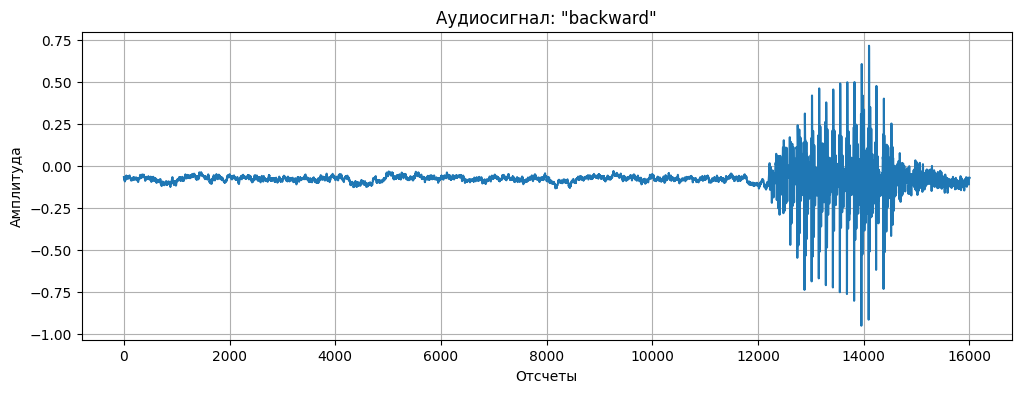

In [3]:
# Загрузка примера из датасета SPEECHCOMMANDS
# Этот датасет доступен "из коробки"
dataset = torchaudio.datasets.SPEECHCOMMANDS(root=".", download=True)

# Взятие первого примера
audio_sample, sample_rate, label, speaker_id, utterance_number = dataset[0]
audio_sample = audio_sample[0]

print(f"Частота дискретизации: {sample_rate} Гц")
print(f"Длительность: {len(audio_sample)/sample_rate:.2f} секунд")
print(f"Метка: {label}")

# Визуализация аудио
plt.figure(figsize=(12, 4))
plt.plot(audio_sample.numpy())
plt.title(f'Аудиосигнал: "{label}"')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.show()


/tmp/ipython-input-3994899847.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  watermarked_audio = wm.encode(audio_sample, torch.tensor(text))


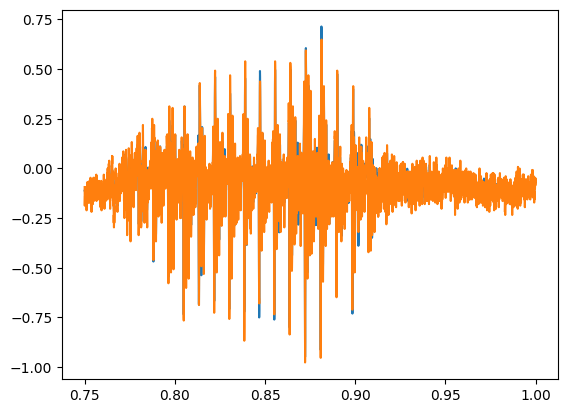

Original bits: tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1])
Decoded bits:  tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], dtype=torch.uint8)

SNR: 8.59
PSNR: 27.63

NC: 1.00
BER: 0.00%


In [4]:
text = torch.tensor([0,1,1,0,1,1,0,1,1,0,1])
eps_noise = 0.1
set_seed()

num_bits = len(text)

wm = Watermark(decomposition_type = "SVD",
               decomposition_params = dict(beta = 10),
               need_LWT = False,
               need_FWHT = True,
               encryption_type = 'bernoulli',
               encryption_params = dict(y0 = 0.2),
               frame_size  = 64)

watermarked_audio = wm.encode(audio_sample, torch.tensor(text))
new_sample_rate = sample_rate #int(sample_rate*(0.9))
attacked_audio = torch.from_numpy(
    AudioData(
        values = np.array(watermarked_audio),
        sr = sample_rate
    ).add_noise(snr = 10, mode="clip")\
    .mp3_compression()\
    .resample(sr = new_sample_rate)\
    .requantize(quantization = 8)\
    .y
)

bits = wm.decode(attacked_audio, num_bits)

output_path = "output_audio.wav"
torchaudio.save(output_path, attacked_audio, new_sample_rate)

plt.plot(np.arange(sample_rate)[-sample_rate//4:]/sample_rate,  np.array((audio_sample[-sample_rate//4:]).squeeze()))
plt.plot(np.arange(new_sample_rate)[-new_sample_rate//4:]/new_sample_rate, np.array((attacked_audio[-new_sample_rate//4:]).squeeze()))
plt.show()

print("Original bits:", text)
print("Decoded bits: ", bits)
print()
print(f"SNR: {calculate_snr(audio_sample, attacked_audio):.2f}")
print(f"PSNR: {calculate_psnr(audio_sample, attacked_audio):.2f}")
print()
print(f"NC: {calculate_nc(text, bits):.2f}")
print(f"BER: {calculate_ber(text, bits):.2f}%")